# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
ciao


# Install and import dependencies

In [ ]:
# !pip install tensorflow_addons contractions emoji ekphrasis --quiet

     |████████████████████████████████| 1.1 MB 31.4 MB/s 
     |████████████████████████████████| 175 kB 69.2 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
     |████████████████████████████████| 287 kB 78.1 MB/s 
     |████████████████████████████████| 106 kB 76.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


Load dependencies required

In [ ]:
# import tensorflow as tf
# import keras

# from keras import Model, Sequential
# from keras.layers import Embedding, TextVectorization, Input, LSTM, Bidirectional, Dropout, Dense, SpatialDropout1D, Attention, Conv1D, MaxPooling1D, Add, Flatten, Reshape, GRU
# import keras.backend as K
# from keras.losses import Loss
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras.models import load_model
# from keras.initializers import Constant
# from keras.regularizers import l2
# from keras.metrics import Mean

# from tensorflow.keras.losses import SparseCategoricalCrossentropy, Reduction
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.optimizers import Adam

# import tensorflow_addons as tfa

# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, f1_score
# import numpy as np
# import re
# from dataclasses import dataclass

# import contractions, emoji

# from ekphrasis.classes.preprocessor import TextPreProcessor
# from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.emoticons import emoticons

In [1]:
from dataclasses import dataclass
import os
import os.path
import re
import shutil
import typing
import urllib.request

import keras
import keras.layers
import numpy as np
import pandas as pd
import sklearn.preprocessing
import tqdm

# Dataset

## Download the data

- Download the dataset
- Unzip the dataset in the local path

In [2]:
file_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zip_name = os.path.join(os.getcwd(), "dependency_treebank.zip")
file_name = os.path.join(os.getcwd(), "dependency_treebank")

if not os.path.isdir(file_name):
    if not os.path.isfile(zip_name):
        with urllib.request.urlopen(file_url) as res, open(zip_name, "wb") as f:
            shutil.copyfileobj(res, f)
    shutil.unpack_archive(zip_name, os.getcwd())

## Load the data

- Read the data for training (1-100), validation (101-150) and test (151-199)

In [5]:
class DataLoader:
    PUNCTUATIONS = r"[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self):
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(self, start_i: int, end_i: int, split: bool = True, desc: typing.Optional[str] = None):
        df_X = pd.DataFrame()
        df_y = pd.DataFrame()

        for i in tqdm.trange(start_i, end_i+1, desc=f"Reading {desc} data"):
            idx_len = "0" * (3 - len(str(i)))
            data_file = os.path.join(file_name, f"wsj_0{idx_len}{i}.dp")
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]
            
            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                # New line encountered, split the following lines in a new sentence
                if len(c) == 0:
                    i += 1
                    Xrows.append("")
                    yrows.append("")
                    continue
                # Process sentence
                assert len(c) == 3
                if self.prog.fullmatch(c[1]) is None:
                    Xrows[i] += " " + c[0]
                    yrows[i] += " " + c[1]

            # X dataframe
            new_X = pd.DataFrame([r.split(" ") if split else r for r in Xrows])
            df_X = pd.concat([df_X, new_X], ignore_index=True)
            # y dataframe
            new_y = pd.DataFrame([r.split(" ") if split else r for r in yrows])
            df_y = pd.concat([df_y, new_y], ignore_index=True)
        return df_X, df_y

data_loader = DataLoader()
df_Xtrain, df_ytrain = data_loader(1, 100, desc="train")
df_Xval, df_yval = data_loader(101, 150, desc="validation")
df_Xtest, df_ytest = data_loader(151, 199, desc="test")

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 88.85it/s]


## Closer look at datasets

In [4]:
df_Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,,Pierre,Vinken,61,years,old,will,join,the,board,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,Mr.,Vinken,is,chairman,of,Elsevier,N.V.,the,Dutch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,Rudolph,Agnew,55,years,old,and,former,chairman,of,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,A,form,of,asbestos,once,used,to,make,Kent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,The,asbestos,fiber,crocidolite,is,unusually,resilient,once,it,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ytrain.head()

,0,1,2,3,4,5,6,7,8,9,...,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597
0,NNP,NNP,CD,NNS,JJ,MD,VB,DT,NN,IN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NNP,NNP,CD,NNS,JJ,CC,JJ,NN,IN,NNP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DT,NN,IN,NN,RB,VBN,TO,VB,NNP,NN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NNS,IN,JJ,JJ,NNS,VBD,TO,VB,IN,NNS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NNP,NNP,NN,NN,IN,NNP,NNP,CC,NNP,WDT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Encoding of labels

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(df_ytrain.values.ravel())

df_ytrain = df_ytrain.apply(lambda s: pd.Series(le.transform(s[s.notnull()]), index=s[s.notnull()].index))
df_yval = df_yval.apply(lambda s: pd.Series(le.transform(s[s.notnull()]), index=s[s.notnull()].index))
df_ytest = df_ytest.apply(lambda s: pd.Series(le.transform(s[s.notnull()]), index=s[s.notnull()].index))

In [ ]:
print(f"Number of classes: {len(le.classes_)}")

Number of classes: 41


## TODO
- Distribution of classes
- Sentences length
    - Split sentences too long

# Tokenization

### Encoding of the input

In [ ]:
class Tokenizer:
    vocab_size = 20000
    max_length = 128
    embedding_dim = 300
    layer: TextVectorization

    def __init__(self, data, vocab_size: int = 10000, max_length: int = 512, embedding_dim: int = 300):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_dim = embedding_dim

        self.layer = TextVectorization(
            max_tokens=vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=max_length,
        )
        self.layer.adapt(data, batch_size=32)

    def encode(self, texts):
        encoded_texts = self.layer(texts)
        return encoded_texts.numpy()

    def get_layer(self):
        return self.layer

    def get_embedding_dim(self):
        return self.embedding_dim

Xtrain = df_Xtrain.T.apply(lambda x: " ".join(x.dropna().tolist())).tolist()
# ytrain = df_ytrain.apply(lambda x: " ".join(x.dropna().tolist())).tolist()
print(f"XTrain length: {len(Xtrain)}")

tokenizer = Tokenizer(Xtrain)

Xtrain = tokenizer.encode(Xtrain)
# def get_tensor_dataset(x, y, buffer=1000, batch=32):
#     # return (
#     #     tf.data.Dataset.from_tensor_slices((x, y))
#     #     .shuffle(buffer, seed=conf_m1.SEED)
#     #     .batch(batch))
#     return (tf.data.Dataset.from_tensor_slices((x, y)))

XTrain length: 100


In [ ]:
# train_classifier_ds = get_tensor_dataset(x_train, y_train)
# val_classifier_ds = get_tensor_dataset(x_val, y_val)

# xtest_raw_ds = (tf.data.Dataset.from_tensor_slices(x_test).batch(256))

In [ ]:
Xtrain[1]

array([1849, 6979, 1107,   59,  348,    7,  516,  162,    3, 3134, 1254,
        589, 1915,   21,  455,    5, 1200,  269,    3,   41, 1320,  510,
       6404,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# Embedding layer

## Download

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip -qq glove.6B.zip

--2022-11-11 17:33:35--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 52.1.251.133, 52.202.148.66, 2600:1f18:147f:e800:8a4d:e339:6450:82c9, ...
Connecting to huggingface.co (huggingface.co)|52.1.251.133|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B%20filename%3D%22glove.6B.zip%22&Expires=1668447216&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzY0NzEzODJjZGQ4Mzc1NDRiZjNhYzcyNDk3YTM4NzE1ZTg0NTg5N2QyNjViMmI0MjRiNDc2MTgzMjAwOWM4Mzc~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj1hdHRhY2htZW50JTNCJTIwZmlsZW5hbWUlM0QlMjJnbG92ZS42Qi56aXAlMjIiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2Njg0NDcyMTZ9fX1dfQ__&Signature=UIPoEDM~gLcQbexSzIA5NzEObMNYd5m0a6WSA19Yw-ws2daMYClc2

## Configure pretrained embedding

In [ ]:
glove_path = f"glove.6B.{tokenizer.get_embedding_dim()}d.txt"
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400001 word vectors.


In [ ]:
vectorize_layer = tokenizer.get_layer()

vocabulary = vectorize_layer.get_vocabulary()
vocabulary_size = vectorize_layer.vocabulary_size()
print(vocabulary_size)
word_index = dict(zip(vocabulary, range(vocabulary_size)))

hits = 0
misses = 0

embedding_matrix = np.zeros((vocabulary_size, tokenizer.get_embedding_dim()))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

7394
Converted 7033 words (361 misses)


# Model

In [ ]:
@dataclass
class Parameters:
    BATCH = 80
    LR = 5e-3
    L2 = 0.02
    SD_RATE = 0.3
    D_RATE = 0.3
    LSTM_UNITS = 128
    LSTM_LAYERS = 3

m1_para = Parameters()

inputs = Input((conf_m1.MAX_LEN,), dtype=tf.int64)
embedded = Embedding(conf_m1.VOCAB_SIZE, 
                    conf_m1.EMBED_DIM, 
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False,
                    mask_zero=True)(inputs)

x = SpatialDropout1D(m1_para.SD_RATE)(embedded)

for i in range(m1_para.LSTM_LAYERS):
    ret_seq = i != m1_para.LSTM_LAYERS - 1

    x = Bidirectional(LSTM(m1_para.LSTM_UNITS, return_sequences=ret_seq, recurrent_regularizer=l2(m1_para.L2)))(x)
    x = Dropout(m1_para.D_RATE)(x)

outputs = Dense(7, activation="softmax")(x)
model = Model(inputs, outputs)

opt = Adam(learning_rate=m1_para.LR)
model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=[tfa.metrics.F1Score(num_classes=7, average='macro')])
    
model.summary()

early_stopping = EarlyStopping(monitor="val_loss", patience=2)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.3)

history = model.fit(train_classifier_ds.shuffle(1000, seed=42).batch(m1_para.BATCH), 
          validation_data=val_classifier_ds.shuffle(1000, seed=42).batch(m1_para.BATCH), 
          epochs=6,
          callbacks=[reduce_lr, early_stopping])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 64, 300)           6000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 64, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_12 (Bidirecti  (None, 64, 256)          439296    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 64, 256)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 64, 256)          3942

### Evaluate the model

The reached F1 macro average score reached is **0.6070**

In [ ]:
xtest_raw_ds = (tf.data.Dataset.from_tensor_slices(x_test).batch(256))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(xtest_raw_ds), axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.7870    0.7738    0.7804      1972
           1     0.6118    0.6448    0.6278      1647
           2     0.5759    0.5997    0.5876       677
           3     0.5038    0.4650    0.4836       572
           4     0.6012    0.5521    0.5756       355
           5     0.5859    0.5000    0.5395       116
           6     0.6322    0.6790    0.6548        81

    accuracy                         0.6585      5420
   macro avg     0.6140    0.6021    0.6070      5420
weighted avg     0.6587    0.6585    0.6582      5420



### Plot the loss and the F1 score

The callback ReduceLROnPlateau helps in reducing the loss function even more and reach higher score. In this case it is applied to the forth epoch by reducing the learning rate from 0.005 to 0.0015.

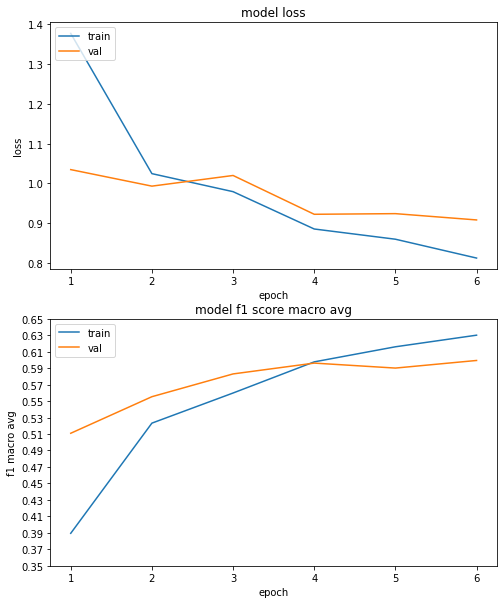

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 10))

x_len = np.arange(1, len(history.history['f1_score'])+ 1)

axs[0].plot(x_len, history.history['loss'])
axs[0].plot(x_len, history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')
axs[0].set_xticks(x_len)

axs[1].plot(x_len, history.history['f1_score'])
axs[1].plot(x_len, history.history['val_f1_score'])
axs[1].set_title('model f1 score macro avg')
axs[1].set_ylabel('f1 macro avg')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
axs[1].set_xticks(x_len)
axs[1].set_yticks(np.arange(0.35, 0.65, step=0.02))

fig.show()

### Save model

In [ ]:
model_name = "BiLSTM-6070"

In [ ]:
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070'
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070/Weights'
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070/Model'

In [ ]:
model.save_weights(f'/content/drive/MyDrive/DLExam/{model_name}/Weights/best_model.h5')

# Conclusions

Only one model has been developed, but its parameters have been tuned to avoid overfitting and reach higher metric values. 

To sum up, the F1 macro average reached on the test set is: **0.6070**.

The dataset is not considered to be in the current folder, so some paths should be changed to try it.

The weights can be found [here](https://drive.google.com/drive/folders/1-5ie089FMql0_5biZWaMGipZghk8L2Hz?usp=sharing).